In [1]:
import xarray as xr
import numpy as np
import dask

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
mt_path = "/pub/mariant3/WarmWaterMasses/data/"

ocetrac_labels = xr.open_dataset(f"{mt_path}/ocetracv9/ocetrac-v9-blobs-tos-t1-r1-msq0-01860315-01891214-region.nc", chunks={'time':1})
labels = ocetrac_labels.blobs.load()

# wmt is the manso wmt budget
wmt = xr.open_dataset(
    f"{mt_path}WMT_data/0186-0189_wmt-daily.nc").sel(
    time=slice("0186","0189")
) 

heat_budget = xr.open_dataset(
    f"{mt_path}budgets/heat_budgets/heat-budget-id-373-full-column.nc"
)
heat_budget_10m = xr.open_dataset(
    f"{mt_path}budgets/heat_budgets/heat-budget-id-373-10m.nc"
)

In [ ]:
# Uncomment if needed for analayis

# hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"

# ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})
# ds = ds.isel(yh=slice(1, None), yq=slice(None, -1), xh=slice(1,None), xq=slice(None, -1)) # realign cell center/corner coordinates

# snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
# # Rename snapshot time coordinates to time_bounds so they can later be merged with ds
# snap = snap.rename({
#     **{'time': 'time_bounds'},
#     **{v: f"{v}_bounds" for v in snap.data_vars}
#     })

# static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")

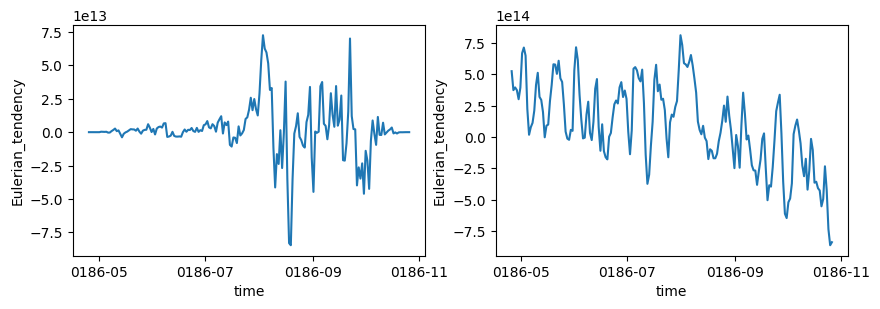

In [3]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
heat_budget.Eulerian_tendency.plot()
plt.subplot(1,2,2)
heat_budget_10m.Eulerian_tendency.plot()

In [4]:
int_heat_tendency = ((heat_budget['Eulerian_tendency'] * 86400).cumsum('time'))
int_heat_tendency_10m = ((heat_budget_10m['Eulerian_tendency'] * 86400).cumsum('time'))

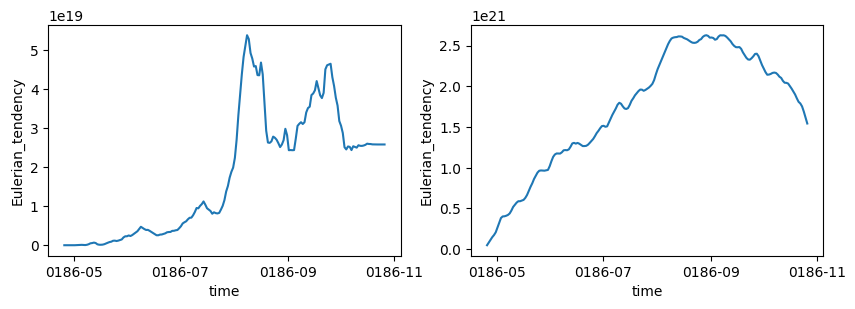

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
int_heat_tendency.plot()
plt.subplot(1,2,2)
int_heat_tendency_10m.plot()

In [6]:
# indices for heat_budget
idx_max = int_heat_tendency.argmax()
print(idx_max)

idx_form = np.arange(0, idx_max +1)
print(idx_form)

idx_destroy = np.arange(idx_max, int_heat_tendency.time.size +1)
print(idx_destroy)

# indices for heat_budget_10m
idx_max_10m = int_heat_tendency_10m.argmax()
print(idx_max_10m)

idx_form_10m = np.arange(0, idx_max_10m +1)
print(idx_form_10m)

idx_destroy_10m = np.arange(idx_max_10m, int_heat_tendency_10m.time.size +1)
print(idx_destroy_10m)

<xarray.DataArray 'Eulerian_tendency' ()>
array(105)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105]
[105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185]
<xarray.DataArray 'Eulerian_tendency' ()>
array(126)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32

In [7]:
def plot_heat_budget(heat_budget, int_heat_tendency, idx_max, idx_destroy):

    fig, ax = plt.subplots(figsize=(18,3))

    int_heat_tendency.isel(time=slice(0, idx_destroy[-1])).plot(ax=ax, label=r"heat tendency",linewidth=4)

    Gsurf = (heat_budget['surface_exchange_flux'] * 86400).cumsum('time')
    Gsurf.plot(ax=ax, label=r"surface_exchange_flux")

    diffusion = (heat_budget['diffusion'] * 86400).cumsum('time')
    diffusion.plot(ax=ax, label=r"diffusion")
    
    advection = (heat_budget['advection'] * 86400).cumsum('time')
    advection.plot(ax=ax, label=r"advection")

    bottom_flux = (-heat_budget['bottom_flux'] * 86400).cumsum('time')
    bottom_flux.plot(ax=ax, label=r"bottom_flux")

    frazil_ice = (heat_budget['frazil_ice'] * 86400).cumsum('time')
    frazil_ice.plot(ax=ax, label=r"frazil_ice")
    
    all_terms = Gsurf + advection + diffusion + bottom_flux + frazil_ice
    all_terms.plot(ax=ax, label=r"all_terms")

    ax.plot(int_heat_tendency.time.isel(time=idx_max), int_heat_tendency.isel(time=idx_max), 'wo', markeredgecolor='k', label=r"$\max\{\mathcal{M}(\Theta)\}$")

    ax.tick_params(axis='both', which='major')
    # ax.set_ylim(-3e+16, 3e+16)
    ax.set_title("")
    ax.set_ylabel("heat tendencies")
    ax.set_xlabel("")

    ax.grid(True, alpha=0.9)
    ax.legend(loc=2)
    plt.tight_layout()
    # plt.savefig("/pub/mariant3/WarmWaterMasses/figures/integrated-heat_budget-event-373-10m.png", dpi=300, bbox_inches='tight')
    plt.show()

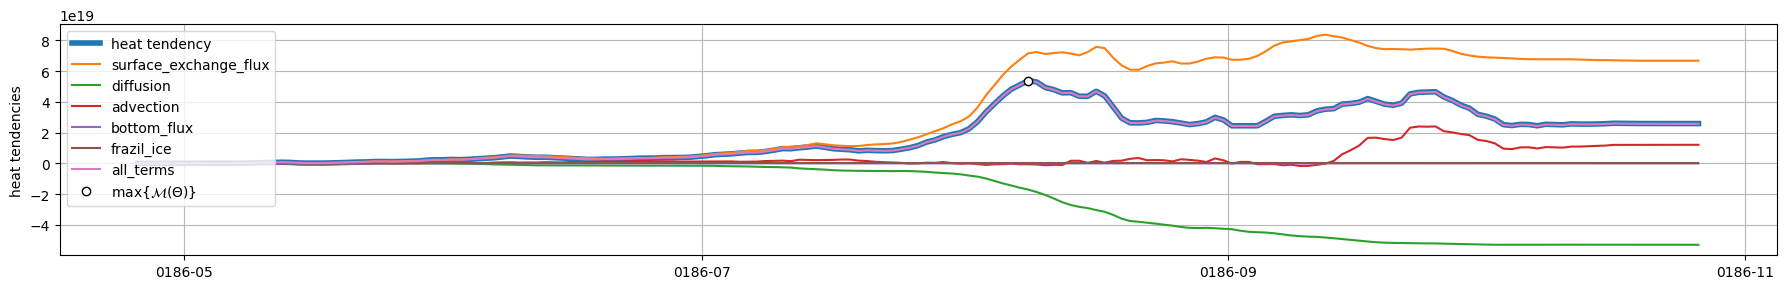

In [8]:
plot_heat_budget(heat_budget, int_heat_tendency, idx_max, idx_destroy)

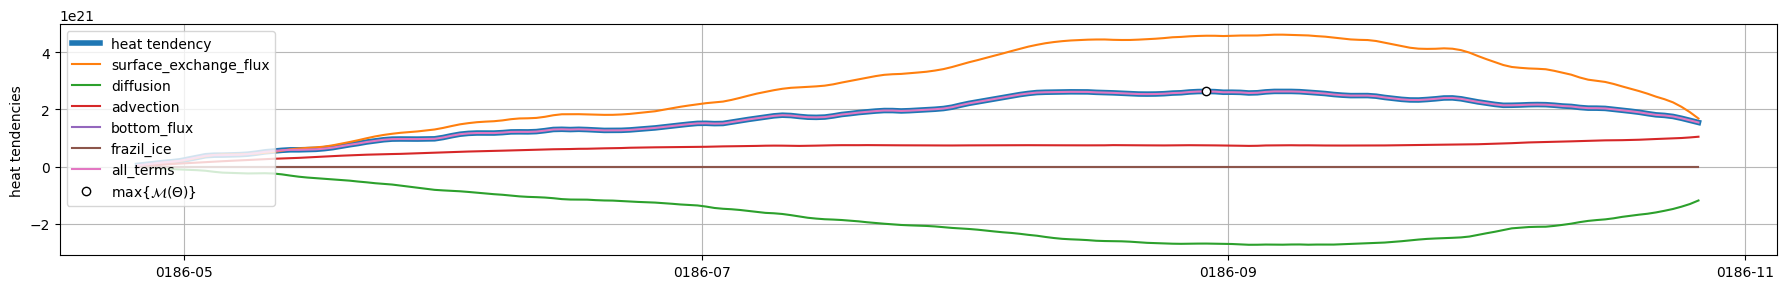

In [9]:
plot_heat_budget(heat_budget_10m, int_heat_tendency_10m, idx_max_10m, idx_destroy_10m)